In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import pandas as pd
import matplotlib.pyplot as plt
import json
import string
import os
from PIL import Image
import datetime

from typing import Any


In [2]:
root_dir = 'dataset/chest_xray/chest_xray/'
train_data_path = 'train'
test_data_path = 'test'
val_data_path = 'val'

In [3]:
train_transforms =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#test and validation
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
train_dataset = torchvision.datasets.ImageFolder(
    root=root_dir + train_data_path,
    transform=train_transforms
)
test_dataset = torchvision.datasets.ImageFolder(
    root=root_dir +test_data_path,
    transform=test_transforms
)
val_dataset = torchvision.datasets.ImageFolder(
    root=root_dir +val_data_path,
    transform=test_transforms
)
BATCH_SIZE = 64

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_loader.dataset))
print(len(test_loader.dataset))
print(len(val_loader.dataset))

classes = train_dataset.classes
print(classes)
print(train_dataset.class_to_idx)

5216
624
16
['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


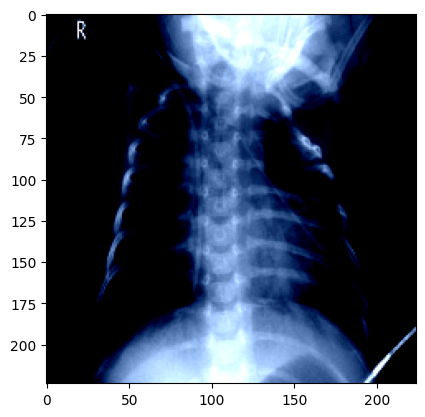

Label: 1


In [7]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1,2,0)
label = train_labels[1]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

In [8]:
class Network(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(3, 12, 3, stride=1, padding=1)
        # ((width - kernel_size + 2*padding)/stride) + 1
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        # shape now is 16, 12, 112, 112
        self.conv2 = nn.Conv2d(12, 16, 3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        #16, 16, 112, 112
        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()

        #hardcoded out_features but same as number of classes -> (NORMAL, PNEUMONIA) = 2
        self.fc1 = nn.Linear(32*112*112, out_features=784)
        self.fc2 = nn.Linear(784, 49)
        self.drop = nn.Dropout(0.5)
        self.fc3 = nn.Linear(49, 2)


    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        output = self.conv2(output)
        output = self.relu2(output)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        #fc -> we need to reshape it
        output = output.view(-1, 32*112*112)
        output = self.fc1(output)
        output = self.fc2(output)
        # dropout only for training !!!
        output = self.drop(output)
        output = self.fc3(output)
        return output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
net = Network()
net.to(device)

cuda


Network(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc1): Linear(in_features=401408, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=49, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=49, out_features=2, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)

In [11]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [12]:
EPOCH = 12

def train(net, optimizer, criterion, train_loader, val_loader, epochs=10, device='cpu'):
    for epoch in range(epochs):  # loop over the dataset multiple times
        net.train()
        training_loss = 0.0
        valid_loss = 0.0

        for _, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        writer.add_scalar('Loss/train', training_loss, epoch)
        net.eval()
        num_correct = 0
        num_examples = 0
        for _, data in enumerate(val_loader, 0):
            optimizer.zero_grad()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1],
                                labels)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        writer.add_scalar('Loss/valid', valid_loss, epoch)
        writer.add_scalar('accuracy', num_correct / num_examples, epoch)
        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
            valid_loss, num_correct / num_examples))
    print('Finished Training')
    # writer.flush() # to make sure all is saved to disk

train(net2, optimizer, criterion, train_loader, val_loader, EPOCH, device)

Epoch: 0, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.38
Epoch: 1, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.38
Epoch: 2, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 3, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.38
Epoch: 4, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 5, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.38
Epoch: 6, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 7, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 8, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 9, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 10, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.44
Epoch: 11, Training Loss: 0.69, Validation Loss: 0.70, accuracy = 0.38
Finished Training


In [13]:
writer.close()

Testing the model

In [14]:
def test_model(net, test_loader, device="cpu"):
    net.eval()
    num_correct = 0
    num_examples = 0

    for _, data in enumerate(test_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        correct = torch.eq(torch.max(F.softmax(outputs, dim=1), dim=1)[1],
                                labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]

    accuracy = num_correct / num_examples
    print(f"Testing Accuracy: {accuracy}")
    return accuracy

test_model(net2, test_loader, device)

Testing Accuracy: 0.5288461538461539


0.5288461538461539

In [15]:
torch.save(net, f'model_e{EPOCH}_{datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")}.pt')